# SSD object detection: EfficientDet_D5 & MobileNet

**Code provenance**
- This code is from the TF2 course of Lazy Programmer (SSD section):
https://www.udemy.com/course/advanced-computer-vision

- In this notebook, I made some minor modifications so that the generic function defined for loading the saved model accepts another input that specifies the saved model to load. This gives user the flexibility to load any saved model they choose.

**Pretrained models used**
- Instead of ResNet101 pretrained model as in the original notebook, we will use EfficientDet_D5 and MobileNet V1 FPN 640x640. 

- The list of pretrained models available for the application of object detection is:
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

**Dataset used for object detection**
- The dataset used for object detection is from:
https://www.kaggle.com/datasets/abedi756/images

# Clone TF Repo, install API

In [1]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 93478, done.
remote: Counting objects: 100% (3366/3366), done.
remote: Compressing objects: 100% (1891/1891), done.
remote: Total 93478 (delta 1620), reused 3123 (delta 1449), pack-reused 90112
Receiving objects: 100% (93478/93478), 617.27 MiB | 30.40 MiB/s, done.
Resolving deltas: 100% (66552/66552), done.


In [2]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [3]:
!cd models/research/ && cp object_detection/packages/tf2/setup.py . && \
python -m pip install .

Processing /kaggle/working/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 57.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 48

# Libraries

In [4]:
import os
import pathlib
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

2024-03-04 09:25:47.982093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 09:25:47.982183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 09:25:48.147619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download pretrained models, label file

In [6]:
#PRETRAINED MODEL
url1 = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz'
url2 = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz'

PATH_TO_MODEL_DIR1 = tf.keras.utils.get_file(
    fname='efficientdet_d5_coco17_tpu-32',
    origin=url1,
    untar=True)

PATH_TO_MODEL_DIR2 = tf.keras.utils.get_file(
    fname='ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8',
    origin=url2,
    untar=True)

90453990/90453990 [==============================] - 1s 0us/step


In [7]:
PATH_TO_MODEL_DIR1

'/root/.keras/datasets/efficientdet_d5_coco17_tpu-32'

In [8]:
PATH_TO_MODEL_DIR2

'/root/.keras/datasets/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8'

In [9]:
#LABEL FILE
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(
    fname='mscoco_label_map.pbtxt',
    origin=url,
    untar=False)

5056/5056 [==============================] - 0s 0us/step


In [10]:
PATH_TO_LABELS

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [11]:
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


# Load label file

In [12]:
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS,
    use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

# Generic functions for the task of object detection

In [13]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [14]:
def detect_objects(image_path, detect_func):
    print('Running inference for {}... '.format(image_path), end='')
    image_np = load_image_into_numpy_array(image_path)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # Do the detection
    detections = detect_func(input_tensor)
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # show classes
    # unique_classes = set(detections['detection_classes'])
    # print("Classes found:")
    # for c in unique_classes:
    #     print(category_index[c]['name'])

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure(figsize=(15, 10))
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

# SSD with EfficientDet_D5

In [15]:
PATH_TO_SAVED_MODEL1 = PATH_TO_MODEL_DIR1 + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn_1 = tf.saved_model.load(PATH_TO_SAVED_MODEL1)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 56.191182136535645 seconds


Running inference for /kaggle/input/images/images/1478019958179775471.jpg... Done


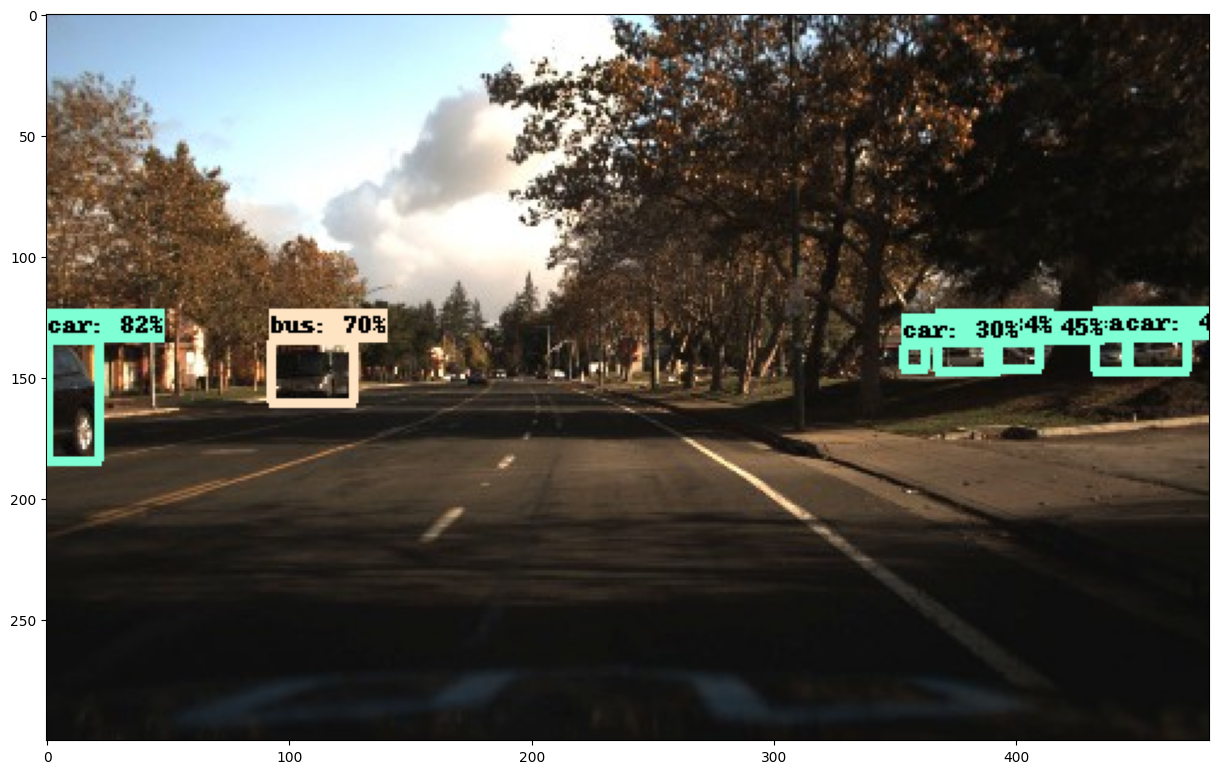

In [21]:
detect_objects('/kaggle/input/images/images/1478019958179775471.jpg', detect_fn_1)

Running inference for /kaggle/input/images/images/1478019957687018435.jpg... Done


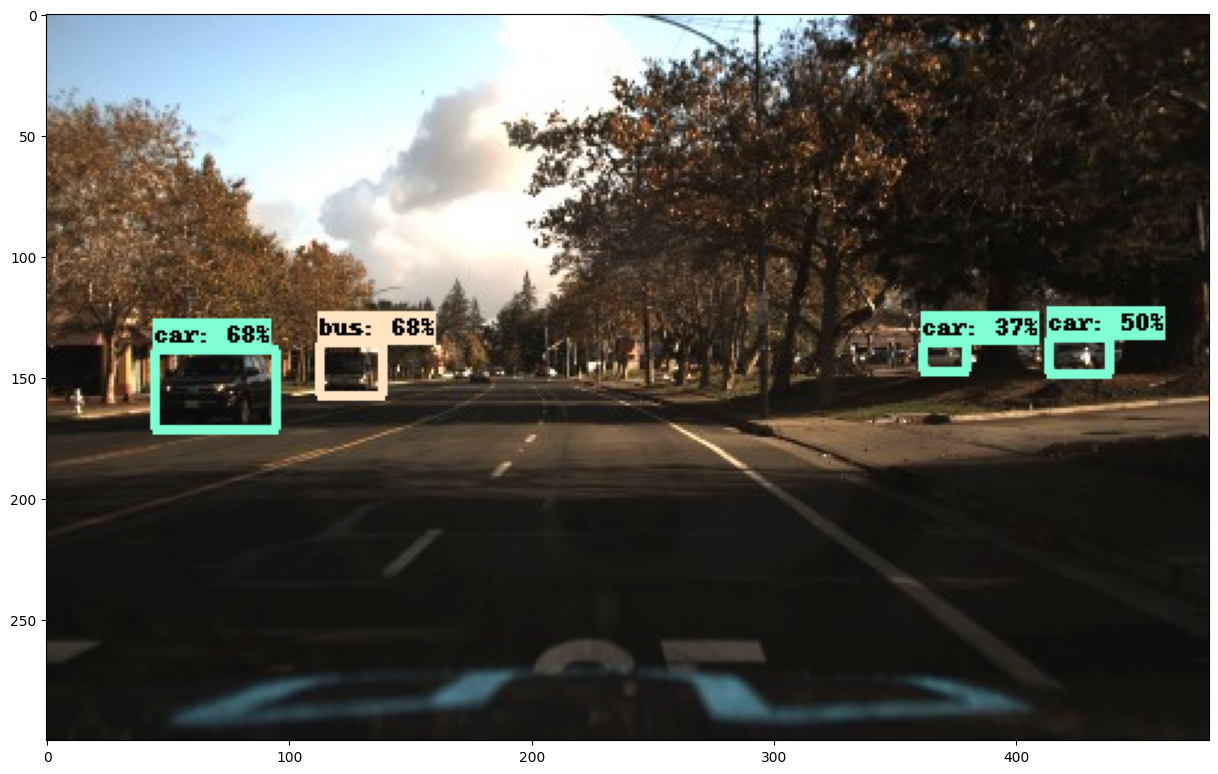

In [22]:
detect_objects('/kaggle/input/images/images/1478019957687018435.jpg', detect_fn_1)

# SSD with MobileNet

In [24]:
PATH_TO_SAVED_MODEL2 = PATH_TO_MODEL_DIR2 + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn_2 = tf.saved_model.load(PATH_TO_SAVED_MODEL2)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 8.521775484085083 seconds


Running inference for /kaggle/input/images/images/1478019958179775471.jpg... Done


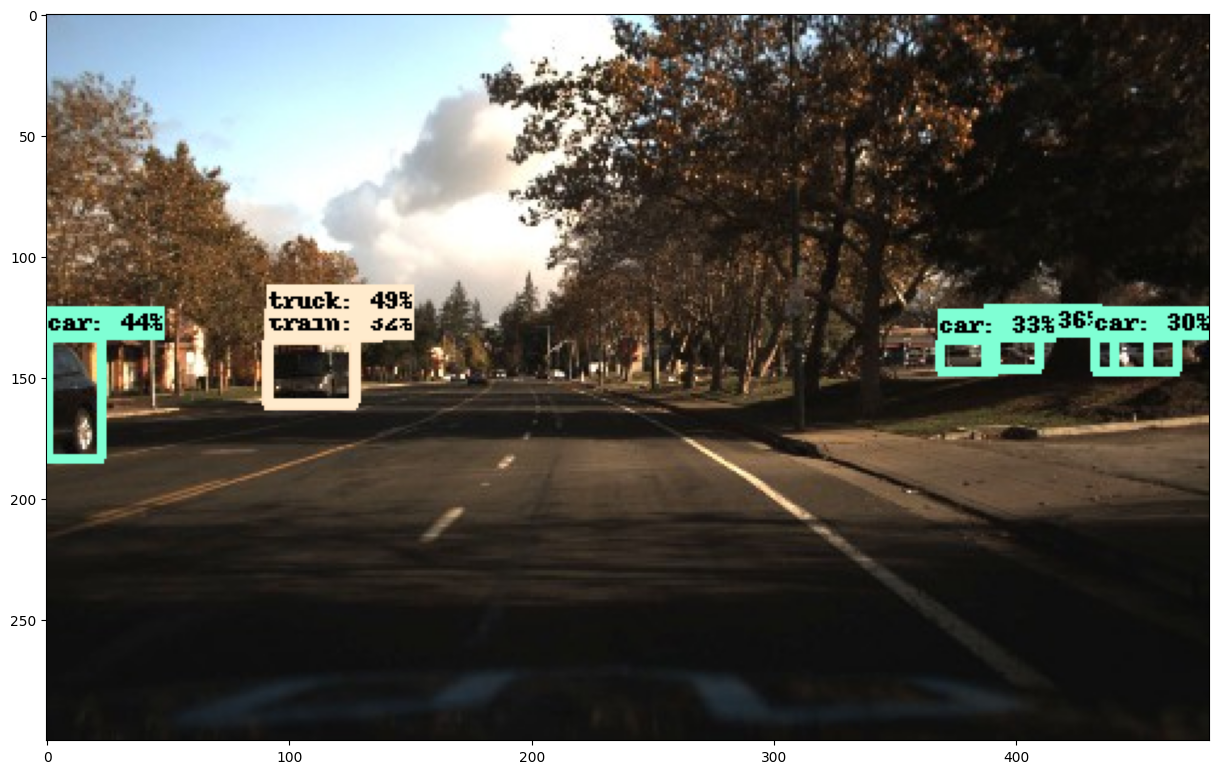

In [26]:
detect_objects('/kaggle/input/images/images/1478019958179775471.jpg', detect_fn_2)

Running inference for /kaggle/input/images/images/1478019957687018435.jpg... Done


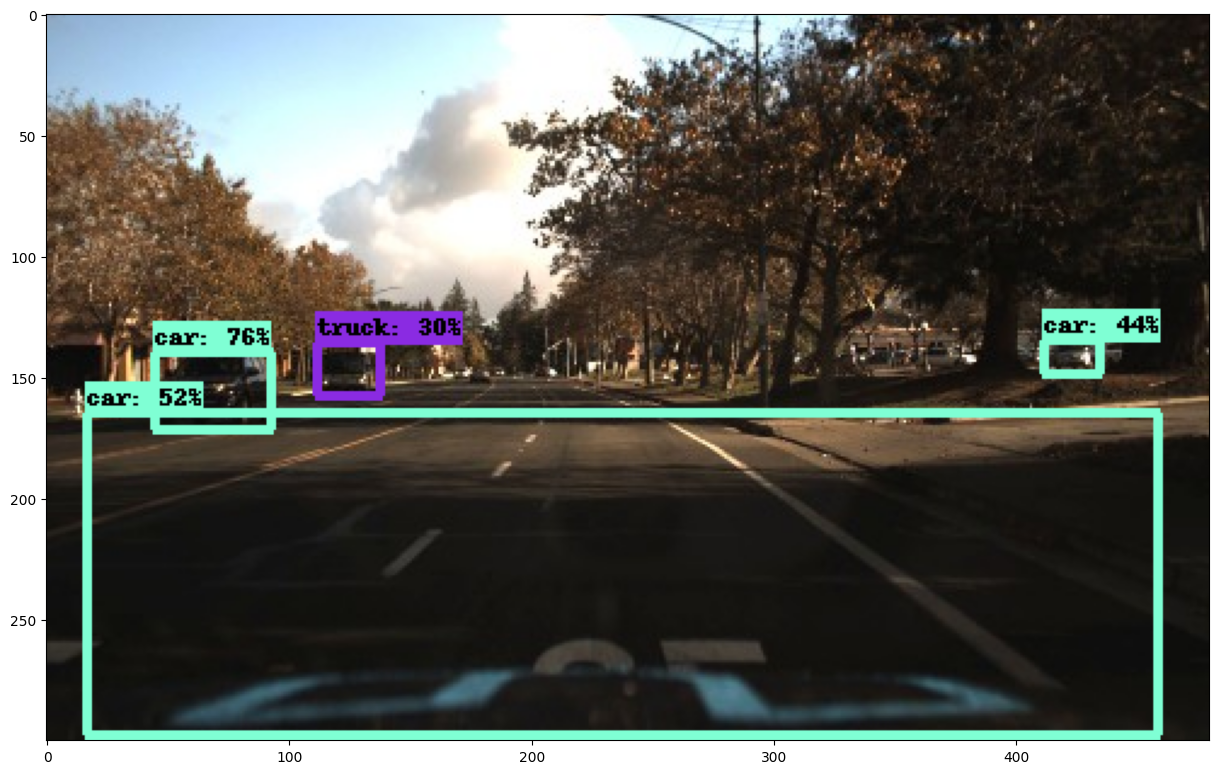

In [25]:
detect_objects('/kaggle/input/images/images/1478019957687018435.jpg', detect_fn_2)

# Comparison of performance between EfficientDet and MobileNet

By passing the same images for object detection through these 2 networks, it's noticeable that MobileNet's performance is not as good as EfficientDet's. This is expected as MobileNet is a smaller structure and this particular model was trained on 640x640 images compared to 1280x1280 for EfficientDet_D5